# Imports

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict
from itertools import product
from main import run_single_tournament

# Resultados

## Gráficos de barra

In [18]:
def plot_final_scores_by_mode(modes, rl_params=None):
    """
    Gera e salva gráficos de barras com a pontuação final de cada agente, para cada modo.
    """
    for mode in modes:
        scores, _ = run_single_tournament(render=False, mode=mode, rl_params=rl_params)
        agents, points = zip(*scores)

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.bar(agents, points)
        ax.set_title(f'Pontuação Final por Agente - Modo: {mode}')
        ax.set_ylabel('Pontuação Final')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

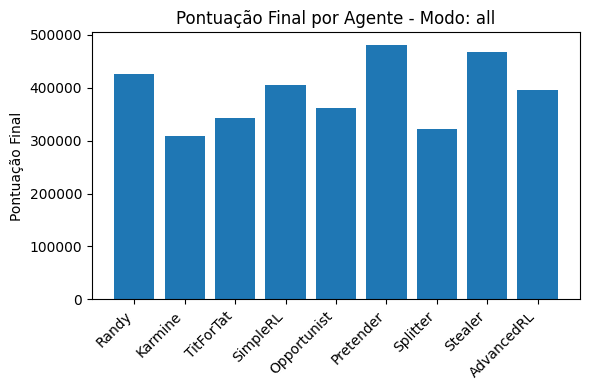

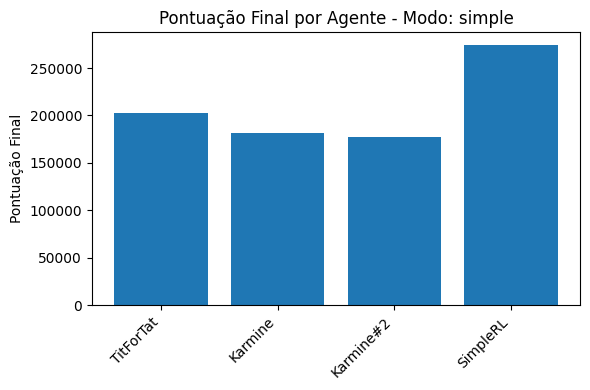

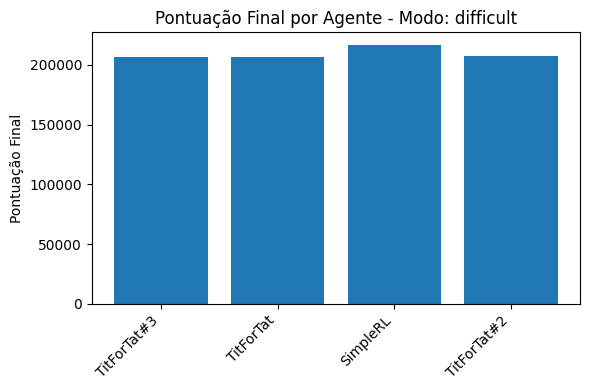

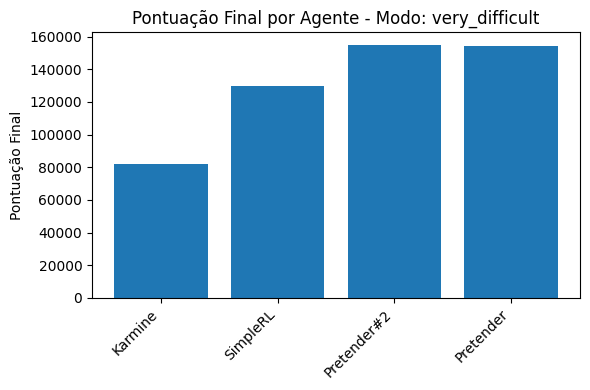

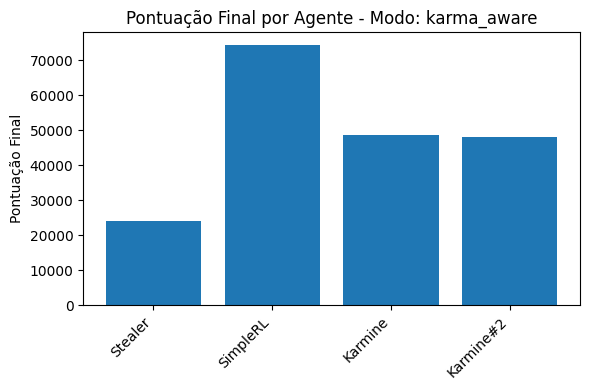

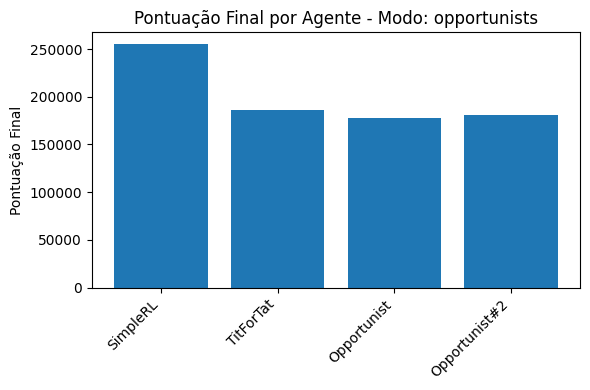

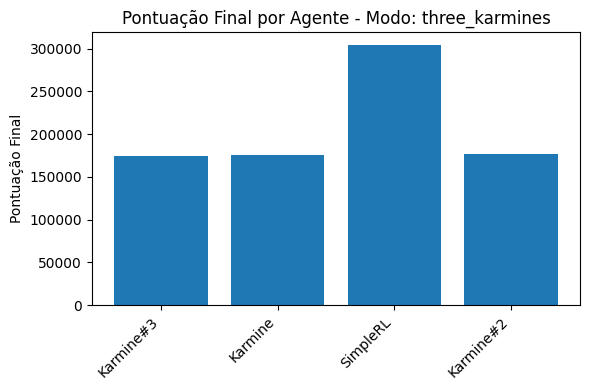

In [19]:
modes = [
    'all',
    'simple',
    'difficult',
    'very_difficult',
    'karma_aware',
    'opportunists',
    'three_karmines'
]
plot_final_scores_by_mode(modes)

## Curvas de aprendizado

In [22]:
def plot_cumulative_learning_curves(modes, rl_params=None):
    plt.figure(figsize=(6, 4))
    for mode in modes:
        _, rewards = run_single_tournament(render=False, mode=mode, rl_params=rl_params)
        cumulative = np.cumsum(rewards)
        plt.plot(range(1, len(cumulative) + 1), cumulative, label=mode)
    
    plt.xlabel('Rodada')
    plt.ylabel('Recompensa acumulada')
    plt.title('Curvas de Aprendizado por Modo')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_avarage_learning_curves(modes, rl_params=None):    
    plt.figure(figsize=(6, 4))
    for mode in modes:
        _, rewards = run_single_tournament(render=False, mode=mode, rl_params=rl_params)
        rewards = np.array(rewards)
        
        rounds = np.arange(1, len(rewards) + 1)
        mean_rewards = rewards.cumsum() / rounds
        plt.plot(rounds, mean_rewards, label=mode)

    plt.xlabel('Rodada')
    plt.ylabel('Recompensa média por rodada')
    plt.title('Curvas de Aprendizado (recompensa média) por Modo')
    plt.legend()
    plt.tight_layout()
    plt.show()

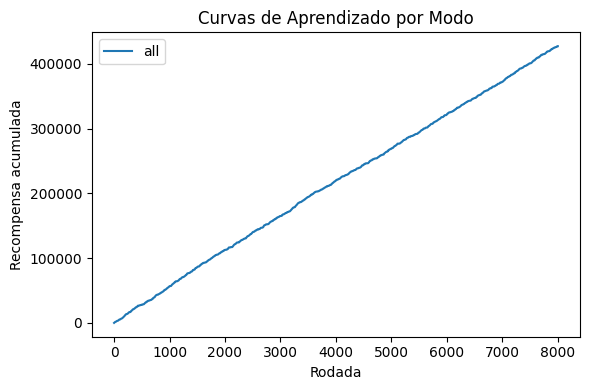

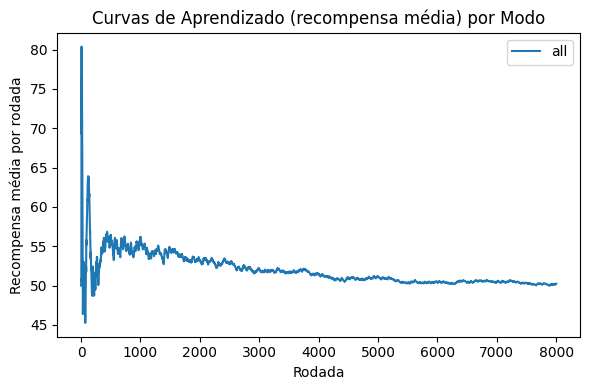

In [25]:

modes = [
    'all',
    # 'simple',
    # 'difficult',
    # 'very_difficult',
    # 'karma_aware',
    # 'opportunists',
    # 'three_karmines'
]
plot_cumulative_learning_curves(modes)
plot_avarage_learning_curves(modes)

## GridSearch

In [34]:
def grid_search(mode: str, param_grid: dict, repetitions: int = 3):
    results = []

    # para cada combinação de hiper‑parâmetros
    for alpha, gamma, epsilon in product(param_grid['alpha'], param_grid['gamma'], param_grid['epsilon']):
        scores_acc = []
        
        for _ in range(repetitions):            
            scores, _ = run_single_tournament(
                render=False,
                mode=mode,
                rl_params=(alpha, gamma, epsilon)
            )
            
            rl_score = next(score for name, score in scores if name.startswith('SimpleRL'))
            scores_acc.append(rl_score)
        
        mean_score = sum(scores_acc) / repetitions
        results.append({
            'alpha':      alpha,
            'gamma':      gamma,
            'epsilon':    epsilon,
            'mean_score': mean_score
        })
    
    return results

In [35]:
mode = 'all'
grid = {
    'alpha':   [0.1, 0.3, 0.5, 0.7, 0.9],
    'gamma':   [0.5, 0.7, 0.9, 0.99],
    'epsilon': [0.01, 0.05, 0.1, 0.2],
}
repetitions = 5

results = grid_search(
    mode=mode,
    param_grid=grid,
    repetitions=repetitions
)

In [36]:
df = pd.DataFrame(results)
df_top10 = df.nlargest(10, 'mean_score').reset_index(drop=True)

print("\nTop 10 combinações de hiperparâmetros (pelo score médio):\n")
print(
    df_top10.to_string(
        index=False,
        float_format="  %.2f".__mod__  # formata floats com 2 casas
    )
)


Top 10 combinações de hiperparâmetros (pelo score médio):

 alpha  gamma  epsilon  mean_score
  0.70   0.99     0.20   457584.97
  0.90   0.99     0.20   443967.93
  0.90   0.99     0.05   441217.63
  0.70   0.99     0.10   435000.14
  0.90   0.99     0.10   432351.57
  0.30   0.99     0.20   432066.38
  0.50   0.50     0.01   429292.08
  0.70   0.70     0.01   427482.16
  0.70   0.99     0.05   427443.20
  0.70   0.50     0.01   426753.68


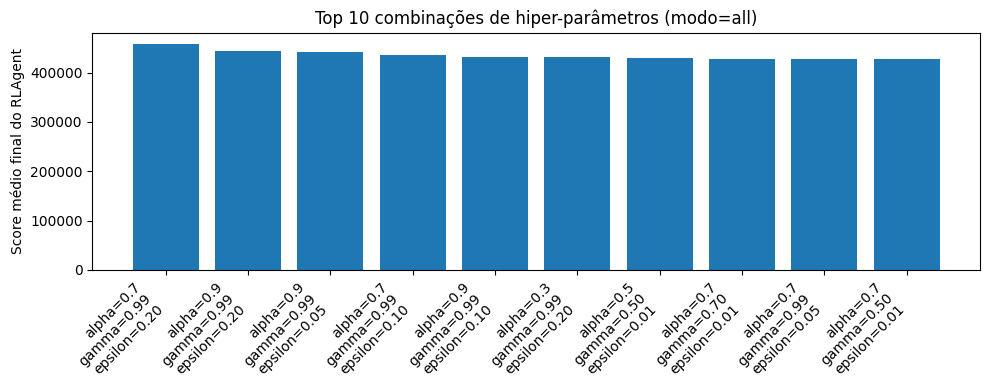

In [41]:
plt.figure(figsize=(10,4))
labels = [
    f"alpha={r.alpha:.1f}\ngamma={r.gamma:.2f}\nepsilon={r.epsilon:.2f}"
    for _, r in df_top10.iterrows()
]
plt.bar(labels, df_top10['mean_score'])
plt.xticks(rotation=45, ha='right')
plt.title(f"Top 10 combinações de hiper-parâmetros (modo={mode})")
plt.ylabel("Score médio final do RLAgent")
plt.tight_layout()
plt.show()